In [1]:
pip install pytorch-lightning

In [2]:
import torch
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pytorch_lightning as pl
from torchmetrics.classification import MulticlassAccuracy
import os
from concurrent.futures import ThreadPoolExecutor
from concurrent.futures import ProcessPoolExecutor, as_completed
import math
import multiprocessing
from tqdm import tqdm


num_cores = os.cpu_count()
num_cores

12

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
path = '/content/drive/MyDrive/Captcha/labels_easy.csv'

data = pd.read_csv(path)

# Load all the words in the easy dataset for tokenization
words = []

for idx, row in data.iterrows():
    label_name = row['label']
    words.append(label_name)

# Get a list of all the alphabets in the entire dataset
letters_list = [list(word) for word in words]
letters_flat = [letter for word in letters_list for letter in word]

# Sort the letters and get both upper and lower case for Hard dataset
letters = sorted(list(set(letters_flat)))
letters = [letter.upper() for letter in list(letters)] + letters

# Special tokens for beginning of sequence, end of sequence, pad token
special_tokens = ['<bos>', '<eos>', '<pad>']
vocab = letters + special_tokens

# Dictionary for conversion of letters to tokens and vice versa
word_2_token = {word: token for token, word in enumerate(vocab)}
token_2_word = {word: token for token, word in word_2_token.items()}

In [5]:
vocab_size = len(word_2_token)
print(f'Vocab size = {vocab_size}')

Vocab size = 51


In [6]:
max_len = len(max(words, key=len)) + 2
print(f'Maximum length with special tokens = {max_len}')

Maximum length with special tokens = 16


In [7]:
# Load and transform each image
def load_and_transform(path, transform=transforms.ToTensor()):
    img = Image.open(path).convert("RGB")
    img.load()
    if transform:
        img = transform(img)
    return img

In [8]:
# Load and transform each image using multi-processing
def load_images_with_progress(filenames, transform=None):
    num_cores = multiprocessing.cpu_count()
    images = []

    with ProcessPoolExecutor(max_workers=num_cores) as executor:
        # Load all the images with progress bar
        images = list(tqdm(executor.map(load_and_transform, filenames), total=len(filenames), desc="Loading images"))

    return images

In [9]:
class OCRDataset(Dataset):
    def __init__(self, csv_files, train, frac=0.9, transform=None):
        # Load all the csv files and make it a single dataframe
        dfs = [pd.read_csv(f) for f in csv_files]
        self.data = pd.concat(dfs, ignore_index=True)
        self.transform = transform

        # Randomly sample fraction of the dataset as train and test
        # Set a random seed to not have train and test set overlap
        train_data = self.data.sample(frac=frac, random_state=42)
        test_data = self.data.drop(train_data.index)

        if train:
            self.data = train_data
        else:
            self.data = test_data

        # Load the filenames(path), images, and the image names
        self.filenames = self.data["filename"].tolist()
        self.images = load_images_with_progress(self.filenames, self.transform)
        self.label_names = self.data['label'].tolist()

    # Returns the length of the dataset class
    def __len__(self):
        return len(self.data)

    # Get the indexed sample from the dataset
    def __getitem__(self, idx):
        label = self.label_names[idx]

        # Create the tokenized label with <bos> in the start, <eos> at the end and
        # <pad> token till the max_len is reached
        seq = [word_2_token['<bos>']] + [word_2_token[letter] for letter in label] + [word_2_token['<eos>']]
        pad_value = word_2_token['<pad>']
        pad_seq = torch.tensor([seq + [pad_value]*(max_len - len(seq))]).squeeze()

        # The input sequence will be till the 2nd last element
        # The target sequence will be shifted by 1 element
        x = pad_seq[:-1]
        y = pad_seq[1:]

        # Mask for the input sequence which will be 0 wherever there is <pad> token
        # And 1 everywhere else
        mask = (x != pad_value)*1

        # Return the image, input sequence, target sequence, mask, word
        return self.images[idx], x, y, mask, self.label_names[idx]

In [10]:
# Paths of the csv files
path_easy = r'/content/drive/MyDrive/Captcha/labels_easy.csv'
path_0 = r'/content/drive/MyDrive/Captcha/labels_Hard_0.csv'
path_1 = r'/content/drive/MyDrive/Captcha/labels_Hard_1.csv'

paths = [path_easy, path_0, path_1]

train_set = OCRDataset(csv_files=paths, train=True)
test_set = OCRDataset(csv_files=paths, train=False)

print()
print()
print(f'Length of train set = {len(train_set):,}')
print(f'Length of test set = {len(test_set):,}')

Loading images: 100%|██████████| 5100/5100 [00:21<00:00, 241.36it/s]




Length of train set = 45,900
Length of test set = 5,100


In [11]:
BATCH_SIZE = 256

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

print(f'Length of train_loader = {len(train_loader)}')
print(f'Length of test_loader = {len(test_loader)}')

Length of train_loader = 180
Length of test_loader = 20


In [12]:
images, x, y, mask, labels = next(iter(train_loader))

In [13]:
images.shape, x.shape, y.shape, mask.shape, labels

(torch.Size([256, 3, 46, 206]),
 torch.Size([256, 15]),
 torch.Size([256, 15]),
 torch.Size([256, 15]),
 ('biLLboaRdS',
  'sO',
  'cHArActer',
  'sUch',
  'UseD',
  'at',
  'pRoCEsses',
  'IMagEs',
  'MeChANICaL',
  'The',
  'WidEly',
  'Is',
  'reAder',
  'aCCUraCy',
  'DeGree',
  'The',
  'WiTh',
  'FOrM',
  'exAMpLe',
  'common',
  'IMAgEs',
  'TExTS',
  'SCAnnER',
  'ANd',
  'mORe',
  'EaCh',
  'stOreD',
  'meChANIcAl',
  'pRINtEd',
  'ReseaRcH',
  'caPaBLE',
  'so',
  'rEAdEr',
  'acCuRACy',
  'aRTificiaL',
  'SiGNS',
  'ARTIFIcIaL',
  'BaNK',
  'CogNitIve',
  'recoRds',
  'PROcesS',
  'DIGITiZing',
  'subTItle',
  'NeEDED',
  'ANd',
  'anD',
  'ConVerSIOn',
  'PROCEssES',
  'FieLD',
  'oPtICAL',
  'mOSt',
  'pRiNTED',
  'needEd',
  'aCCUracy',
  'recoGNiTion',
  'HANDWRITTEN',
  'USED',
  'ONE',
  'AT',
  'bAnk',
  'witH',
  'nEEdeD',
  'FIEld',
  'billboards',
  'WHEThER',
  'BaNk',
  'bUsiNEsS',
  'reCogNITion',
  'wORKED',
  'reCogniTIon',
  'WIdELy',
  'wIdEly',
  'HiGH',
  '

In [14]:
class CNN_Encoder(nn.Module):
    def __init__(self, H, W, n_channels, n_embed):
        super().__init__()

        # Update the Height & Width after every operation for position embedding
        self.H, self.W = H, W

        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=n_channels,
                      out_channels=n_embed,
                      kernel_size=2,
                      stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=n_embed,
                      out_channels=n_embed,
                      kernel_size=2,
                      stride=1),
            nn.BatchNorm2d(n_embed),
            nn.ReLU()
        )

        # Update H & W
        self.H, self.W = math.floor(self.H - 2 + 1), math.floor(self.W - 2 + 1)
        self.H, self.W = math.floor(self.H - 2 + 1), math.floor(self.W - 2 + 1)

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=n_embed,
                      out_channels=n_embed,
                      kernel_size=3,
                      stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=n_embed,
                      out_channels=n_embed,
                      kernel_size=3,
                      stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(n_embed),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Update H & W
        self.H, self.W = math.floor(self.H - 3 + 1), math.floor(self.W - 3 + 1)
        self.H, self.W = math.floor(self.H - 3 + 1), math.floor(self.W - 3 + 1)
        self.H, self.W = math.floor((self.H - 2)/2 + 1), math.floor((self.W - 2)/2 + 1)

        self.avg_pool = nn.AvgPool2d(kernel_size=2)

        # Update H & W
        self.H, self.W = math.floor((self.H - 2)/2 + 1), math.floor((self.W - 2)/2 + 1)

        # Position embedding with Updated H & W
        self.pos_emb = nn.Parameter(torch.randn(1, self.H * self.W, n_embed))


    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.avg_pool(x)

        B, C, _, _ = x.shape
        x = x.reshape(B, self.H*self.W, C)
        x += self.pos_emb

        return x

In [15]:
class Multi_Head_Attention(nn.Module):

    # Multi-Head Attention, takes the image embedding from the Encoder and text embedding from the decoder

    def __init__(self, context_length, n_embed, n_heads):
        super().__init__()
        # Make sure embedding dimension and number of heads are divisible
        assert n_embed % n_heads == 0

        # Key, Query, and Value projections
        self.c_query = nn.Linear(n_embed, n_embed, bias=False)
        self.c_key = nn.Linear(n_embed, n_embed, bias=False)
        self.c_value = nn.Linear(n_embed, n_embed, bias=False)

        # Output projection
        self.c_proj = nn.Linear(n_embed, n_embed, bias=False)
        self.n_heads = n_heads
        self.n_embed = n_embed


    def forward(self, q, k, v, padding_mask=None):
        Bq, Tq, Cq = q.size()
        Bk, Tk, Ck = k.size()
        Bv, Tv, Cv = v.size()

        # Query, Key, Value Projections
        q = self.c_query(q)
        k = self.c_key(k)
        v = self.c_value(v)

        # Split k, q, v into n_heads, each consisting of head_size (head_size = C//n_heads)
        # to apply attention across each head individually
        q = q.view(Bq, Tq, self.n_heads, Cq // self.n_heads).transpose(1, 2)   # Shape = (B, n_heads, Tq, head_size)
        k = k.view(Bk, Tk, self.n_heads, Ck // self.n_heads).transpose(1, 2)   # Shape = (B, n_heads, Tk, head_size)
        v = v.view(Bv, Tv, self.n_heads, Cv // self.n_heads).transpose(1, 2)   # Shape = (B, n_heads, Tv, head_size)

        # q @ k.T with padding mask applied during training to mask out the pad tokens
        attn = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        if padding_mask is not None:
            attn = F.softmax(attn, dim=-1) * padding_mask[:, None, :, None]
        else:
            attn = F.softmax(attn, dim=-1)

        # Shape of attn = (B, n_heads, Tq, Tk)

        y = attn @ v
        # Combine all heads and change the shape to match the input sequence
        y = y.transpose(1, 2).contiguous().view(Bq, Tq, Cq)        # (B, n_heads, Tq, head_size)-->(B, Tq, n_heads, head_size)-->(B, Tq, C)
        y = self.c_proj(y)

        return y

In [16]:
class Multi_Head_Self_Attention(nn.Module):

    # Multi-Head Self Attention, takes the text embedding and applies the attention mechanism on it

    def __init__(self, context_length, n_embed, n_heads):
        super().__init__()
        # Make sure embedding dimension and number of heads are divisible
        assert n_embed % n_heads == 0

        # Key, Query, and Value projections for all heads
        self.c_attn = nn.Linear(n_embed, 3 * n_embed, bias=False)

        # Output projection
        self.c_proj = nn.Linear(n_embed, n_embed, bias=False)
        self.n_heads = n_heads
        self.n_embed = n_embed

        # Mask for masking future tokens (Not required if FlashAttention is used)
        self.register_buffer('bias', torch.tril(torch.ones(context_length, context_length)).
                             view(1, 1, context_length, context_length))

    def forward(self, x, padding_mask=None):
        B, T, C = x.size()  # Batch size, sequence length, embedding dimension

        qkv = self.c_attn(x)                                # Shape = (B, T, 3*C)
        q, k, v = qkv.split(self.n_embed, dim=2)            # Shape = (B, T, C)

        # Split k, q, v into n_heads, each consisting of head_size (head_size = C//n_heads)
        # to apply attention across each head individually
        k = k.view(B, T, self.n_heads, C // self.n_heads).transpose(1, 2)   # Shape = (B, n_heads, T, head_size)
        q = q.view(B, T, self.n_heads, C // self.n_heads).transpose(1, 2)   # Shape = (B, n_heads, T, head_size)
        v = v.view(B, T, self.n_heads, C // self.n_heads).transpose(1, 2)   # Shape = (B, n_heads, T, head_size)

        # q @ k.T with padding mask applied during training to mask out the pad tokens
        # Causal mask also applied for masking future tokens
        attn = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        attn = attn.masked_fill(self.bias[:, :, :T, :T] == 0, float('-inf'))

        if padding_mask is not None:
            attn = F.softmax(attn, dim=-1) * padding_mask[:, None, :, None]
        else:
            attn = F.softmax(attn, dim=-1)

        # Shape of attn = (B, n_heads, T, T)

        y = attn @ v
        y = y.transpose(1, 2).contiguous().view(B, T, C)        # (B, n_heads, T, head_size)-->(B, T, n_heads, head_size)-->(B, T, C)
        y = self.c_proj(y)

        return y

In [17]:
class Decoder(nn.Module):
    def __init__(self, context_length, n_embed, n_heads):
        super().__init__()

        # Multi-Head Self Attention with context length, embedding dimension and number of heads (Takes in text embedding)
        # Followed by Layer Normalization
        self.mhsa = Multi_Head_Self_Attention(context_length, n_embed, n_heads)
        self.layer_norm1 = nn.LayerNorm(n_embed)

        # Multi-Head Attention with with context length, embedding dimension and number of heads (Takes in image and text embedding)
        # Followed by Layer Normalization
        self.mha = Multi_Head_Attention(context_length, n_embed, n_heads)
        self.layer_norm2 = nn.LayerNorm(n_embed)

        # MLP Block
        # Followed by Layer Normalization
        self.mlp = nn.Sequential(
            nn.Linear(n_embed, 2*n_embed),
            nn.GELU(),
            nn.Linear(2*n_embed, n_embed)
        )
        self.layer_norm3 = nn.LayerNorm(n_embed)


    def forward(self, x, enc_out, padding_mask=None):
        # Multi-Head Self Attention with residual connection
        out1 = self.mhsa(x, padding_mask)
        out1 = self.layer_norm1(out1)
        out1 += x

        # Multi-Head Attention with residual connection
        out2 = self.mha(out1, enc_out, enc_out, padding_mask)
        out2 = self.layer_norm2(out2)
        out2 += out1

        # MLP Block
        out = self.mlp(out2)
        out = self.layer_norm3(out)
        out += out2

        return out

In [18]:
class Transformer(nn.Module):
    def __init__(self, H, W, n_channels, n_embed, context_length, vocab_size, n_blocks, n_heads, random_seed=42):
        super().__init__()

        # Generator for consistent token generation
        self.generator = torch.Generator(device=device)
        self.generator.manual_seed(random_seed)

        # Initialize the token and position embedding
        self.context_length = context_length
        self.vocab_size = vocab_size
        self.embedding = nn.Embedding(vocab_size, n_embed)
        self.pos_emb = nn.Parameter(torch.randn((1, context_length, n_embed)))

        # Initialize the Encoder and Decoder(with n_blocks Decoder blocks)
        self.encoder = CNN_Encoder(H, W, n_channels, n_embed)
        self.decoders = nn.ModuleList([Decoder(context_length, n_embed, n_heads) for _ in range(n_blocks)])

        # Final MLP Layer with weight tying
        self.lm_head = nn.Linear(n_embed, vocab_size)
        self.lm_head.weight = self.embedding.weight


    def forward(self, img, x, padding_mask=None):
        enc_out = self.encoder(img)
        x = self.embedding(x)
        T = x.shape[1]
        x += self.pos_emb[:, :T, :]

        for block in self.decoders:
            x = block(x, enc_out, padding_mask)

        # Given T tokens in a sequence, predict the next T tokens
        logits = self.lm_head(x)

        return logits

    # Generate function for inference
    @torch.no_grad()
    def generate(self, img, idx, max_new_tokens=25, T=1.0, k=10):
        self.eval()

        for _ in range(max_new_tokens):

            # If the number of tokens in the sequence is more than the context length,
            # then pick the last context_length tokens
            if idx.shape[1] < self.context_length:
                logits = self(img, idx)
            else:
                logits = self(img, idx[:, -self.context_length:])

            # Pick the the last token logits in the predicted sequence(pad token excluded)
            next_token_logits = logits[:, -1, :-1] / T

            # Apply softmax over the last token logits
            self.probs = F.softmax(next_token_logits, dim=-1)

            # Pick up the topk(k=10) token probabilities with token indices
            self.topk_probs, self.topk_indices = torch.topk(self.probs, k=k, dim=-1)

            # Randomly sample for the next token index with the topk probs
            # That will generate an token index between 0 and k, not 0 and vocab_size
            # To get a token index between 0 and vocab_size, index from the topk_indices with generated index
            idx_next = torch.multinomial(self.topk_probs, num_samples=1, generator=self.generator)
            idx_next = self.topk_indices.squeeze()[idx_next]

            # If the generated token index is the <eos> index, exit the loop
            if idx_next.item() == word_2_token['<eos>']:
                break

            # Concatenate the generated token with the sequence
            idx = torch.cat((idx, idx_next), dim=-1)

        return idx

In [19]:
_, n_channels, H, W = images.shape

In [20]:
transformer = Transformer(
    H=H,
    W=W,
    n_channels=n_channels,
    n_embed=128,
    context_length=15,
    vocab_size=vocab_size,
    n_blocks=10,
    n_heads=16
)

In [21]:
total_params = sum(p.numel() for p in transformer.parameters())
print(f"Number of parameters: {total_params:,}\n")

Number of parameters: 2,413,107



In [22]:
model = transformer.to(device)

In [23]:
criterion = nn.CrossEntropyLoss(reduction="none")
optimizer = optim.AdamW(model.parameters(), lr=1e-3)
metric = MulticlassAccuracy(num_classes=vocab_size).to(device)

In [24]:
num_epochs = 50

epoch_train_losses = []
epoch_train_accuracies = []
epoch_test_losses = []
epoch_test_accuracies = []


for epoch in range(num_epochs):
    model.train()

    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []

    # Training
    for images, x, y, mask, _ in tqdm(train_loader, desc='Training'):

        images = images.to(device)
        x = x.to(device)
        y = y.to(device)
        #mask = ((x != 50) * 1)
        mask = mask.to(device)

        # Set all the gradient values to 0
        optimizer.zero_grad()

        # Forward pass
        logits = model(images, x, mask)

        # Loss calculation with masking the pad tokens
        loss = (criterion(logits.reshape(-1, logits.shape[-1]), y.reshape(-1)) * mask.flatten()).mean()
        accuracy = metric(logits.reshape(-1, logits.shape[-1]), y.reshape(-1)) * 100

        # Backpropagation
        loss.backward()

        # Optimizer update
        optimizer.step()

        train_losses.append(loss.item())
        train_accuracies.append(accuracy)


    # Turn of trainig specific characteristics like Dropout, Norm, etc
    model.eval()

    # Testing
    for images, x, y, mask, _ in tqdm(test_loader, desc='Testing '):
        images = images.to(device)
        x = x.to(device)
        y = y.to(device)
        mask = mask.to(device)

        # Do not Build the activation memory
        with torch.no_grad():
            outputs = model(images, x)

        loss = (criterion(outputs.reshape(-1, outputs.shape[-1]), y.reshape(-1)) * mask.flatten()).mean()
        accuracy = metric(outputs.reshape(-1, outputs.shape[-1]), y.reshape(-1)) * 100

        test_losses.append(loss.item())
        test_accuracies.append(accuracy.item())

    train_loss = torch.mean(torch.tensor(train_losses))
    train_accuracy = torch.mean(torch.tensor(train_accuracies))

    test_loss = torch.mean(torch.tensor(test_losses))
    test_accuracy = torch.mean(torch.tensor(test_accuracies))

    epoch_train_losses.append(train_loss.item())
    epoch_train_accuracies.append(train_accuracy.item())
    epoch_test_losses.append(test_loss.item())
    epoch_test_accuracies.append(test_accuracy.item())

    print()
    print(f"Epoch [{epoch+1}/{num_epochs}]  |   Train Loss: {train_loss:.4f}    |   Train Accuracy: {train_accuracy:.2f} %  |   Test Loss: {test_loss:.4f}  |   Test Accuracy: {test_accuracy:.2f} %")
    print()

Testing : 100%|██████████| 20/20 [00:05<00:00,  3.49it/s]



Epoch [1/50]  |   Train Loss: 13.5154    |   Train Accuracy: 16.47 %  |   Test Loss: 2.9782  |   Test Accuracy: 28.32 %



Testing : 100%|██████████| 20/20 [00:05<00:00,  3.52it/s]



Epoch [2/50]  |   Train Loss: 2.1106    |   Train Accuracy: 30.93 %  |   Test Loss: 1.3588  |   Test Accuracy: 32.70 %



Testing : 100%|██████████| 20/20 [00:05<00:00,  3.51it/s]



Epoch [3/50]  |   Train Loss: 1.0053    |   Train Accuracy: 33.59 %  |   Test Loss: 0.8308  |   Test Accuracy: 35.12 %



Testing : 100%|██████████| 20/20 [00:05<00:00,  3.49it/s]



Epoch [4/50]  |   Train Loss: 0.9450    |   Train Accuracy: 33.94 %  |   Test Loss: 0.7953  |   Test Accuracy: 33.27 %



Testing : 100%|██████████| 20/20 [00:05<00:00,  3.47it/s]



Epoch [5/50]  |   Train Loss: 0.7706    |   Train Accuracy: 34.97 %  |   Test Loss: 0.8333  |   Test Accuracy: 34.88 %



Testing : 100%|██████████| 20/20 [00:05<00:00,  3.47it/s]



Epoch [6/50]  |   Train Loss: 0.7083    |   Train Accuracy: 35.92 %  |   Test Loss: 0.7676  |   Test Accuracy: 35.62 %



Testing : 100%|██████████| 20/20 [00:05<00:00,  3.51it/s]



Epoch [7/50]  |   Train Loss: 0.6849    |   Train Accuracy: 36.63 %  |   Test Loss: 0.7198  |   Test Accuracy: 37.30 %



Testing : 100%|██████████| 20/20 [00:05<00:00,  3.50it/s]



Epoch [8/50]  |   Train Loss: 0.6655    |   Train Accuracy: 37.37 %  |   Test Loss: 0.7116  |   Test Accuracy: 35.44 %



Testing : 100%|██████████| 20/20 [00:05<00:00,  3.52it/s]



Epoch [9/50]  |   Train Loss: 0.6213    |   Train Accuracy: 39.02 %  |   Test Loss: 0.7226  |   Test Accuracy: 34.64 %



Testing : 100%|██████████| 20/20 [00:05<00:00,  3.52it/s]



Epoch [10/50]  |   Train Loss: 0.6030    |   Train Accuracy: 40.14 %  |   Test Loss: 0.6314  |   Test Accuracy: 37.05 %



Testing : 100%|██████████| 20/20 [00:05<00:00,  3.51it/s]



Epoch [11/50]  |   Train Loss: 0.5801    |   Train Accuracy: 41.74 %  |   Test Loss: 0.6830  |   Test Accuracy: 39.81 %



Testing : 100%|██████████| 20/20 [00:05<00:00,  3.54it/s]



Epoch [12/50]  |   Train Loss: 0.5704    |   Train Accuracy: 42.95 %  |   Test Loss: 0.6054  |   Test Accuracy: 40.26 %



Testing : 100%|██████████| 20/20 [00:05<00:00,  3.51it/s]



Epoch [13/50]  |   Train Loss: 0.5514    |   Train Accuracy: 44.85 %  |   Test Loss: 0.5995  |   Test Accuracy: 43.00 %



Testing : 100%|██████████| 20/20 [00:05<00:00,  3.48it/s]



Epoch [14/50]  |   Train Loss: 0.5230    |   Train Accuracy: 47.44 %  |   Test Loss: 0.6538  |   Test Accuracy: 43.02 %



Testing : 100%|██████████| 20/20 [00:05<00:00,  3.47it/s]



Epoch [15/50]  |   Train Loss: 0.4856    |   Train Accuracy: 50.93 %  |   Test Loss: 0.5663  |   Test Accuracy: 46.24 %



Testing : 100%|██████████| 20/20 [00:05<00:00,  3.48it/s]



Epoch [16/50]  |   Train Loss: 0.4525    |   Train Accuracy: 54.34 %  |   Test Loss: 0.4806  |   Test Accuracy: 52.64 %



Testing : 100%|██████████| 20/20 [00:05<00:00,  3.52it/s]



Epoch [17/50]  |   Train Loss: 0.4086    |   Train Accuracy: 58.72 %  |   Test Loss: 0.4463  |   Test Accuracy: 56.61 %



Testing : 100%|██████████| 20/20 [00:05<00:00,  3.48it/s]



Epoch [18/50]  |   Train Loss: 0.3613    |   Train Accuracy: 63.18 %  |   Test Loss: 0.4032  |   Test Accuracy: 60.09 %



Testing : 100%|██████████| 20/20 [00:05<00:00,  3.52it/s]



Epoch [19/50]  |   Train Loss: 0.3152    |   Train Accuracy: 67.91 %  |   Test Loss: 0.3932  |   Test Accuracy: 63.97 %



Testing : 100%|██████████| 20/20 [00:05<00:00,  3.52it/s]



Epoch [20/50]  |   Train Loss: 0.2706    |   Train Accuracy: 72.41 %  |   Test Loss: 0.3305  |   Test Accuracy: 67.58 %



Testing : 100%|██████████| 20/20 [00:05<00:00,  3.35it/s]



Epoch [21/50]  |   Train Loss: 0.2294    |   Train Accuracy: 75.98 %  |   Test Loss: 0.2900  |   Test Accuracy: 72.09 %



Testing : 100%|██████████| 20/20 [00:05<00:00,  3.49it/s]



Epoch [22/50]  |   Train Loss: 0.1960    |   Train Accuracy: 79.38 %  |   Test Loss: 0.2476  |   Test Accuracy: 75.06 %



Testing : 100%|██████████| 20/20 [00:05<00:00,  3.50it/s]



Epoch [23/50]  |   Train Loss: 0.1659    |   Train Accuracy: 82.25 %  |   Test Loss: 0.2156  |   Test Accuracy: 77.48 %



Testing : 100%|██████████| 20/20 [00:05<00:00,  3.49it/s]



Epoch [24/50]  |   Train Loss: 0.1447    |   Train Accuracy: 84.44 %  |   Test Loss: 0.2066  |   Test Accuracy: 80.13 %



Testing : 100%|██████████| 20/20 [00:05<00:00,  3.49it/s]



Epoch [25/50]  |   Train Loss: 0.1254    |   Train Accuracy: 86.14 %  |   Test Loss: 0.1814  |   Test Accuracy: 82.36 %



Testing : 100%|██████████| 20/20 [00:05<00:00,  3.50it/s]



Epoch [26/50]  |   Train Loss: 0.1148    |   Train Accuracy: 87.25 %  |   Test Loss: 0.1795  |   Test Accuracy: 83.14 %



Testing : 100%|██████████| 20/20 [00:05<00:00,  3.52it/s]



Epoch [27/50]  |   Train Loss: 0.0980    |   Train Accuracy: 89.07 %  |   Test Loss: 0.1709  |   Test Accuracy: 83.96 %



Testing : 100%|██████████| 20/20 [00:05<00:00,  3.50it/s]



Epoch [28/50]  |   Train Loss: 0.0866    |   Train Accuracy: 89.99 %  |   Test Loss: 0.1563  |   Test Accuracy: 85.72 %



Testing : 100%|██████████| 20/20 [00:05<00:00,  3.52it/s]



Epoch [29/50]  |   Train Loss: 0.0824    |   Train Accuracy: 90.50 %  |   Test Loss: 0.1621  |   Test Accuracy: 85.42 %



Testing : 100%|██████████| 20/20 [00:05<00:00,  3.52it/s]



Epoch [30/50]  |   Train Loss: 0.0807    |   Train Accuracy: 90.92 %  |   Test Loss: 0.1788  |   Test Accuracy: 85.18 %



Testing : 100%|██████████| 20/20 [00:05<00:00,  3.51it/s]



Epoch [31/50]  |   Train Loss: 0.0719    |   Train Accuracy: 91.62 %  |   Test Loss: 0.1447  |   Test Accuracy: 87.43 %



Testing : 100%|██████████| 20/20 [00:05<00:00,  3.53it/s]



Epoch [32/50]  |   Train Loss: 0.0658    |   Train Accuracy: 92.18 %  |   Test Loss: 0.1315  |   Test Accuracy: 87.66 %



Testing : 100%|██████████| 20/20 [00:05<00:00,  3.53it/s]



Epoch [33/50]  |   Train Loss: 0.0573    |   Train Accuracy: 93.00 %  |   Test Loss: 0.1342  |   Test Accuracy: 87.95 %



Testing : 100%|██████████| 20/20 [00:05<00:00,  3.52it/s]



Epoch [34/50]  |   Train Loss: 0.0582    |   Train Accuracy: 92.89 %  |   Test Loss: 0.1458  |   Test Accuracy: 88.33 %



Testing : 100%|██████████| 20/20 [00:05<00:00,  3.52it/s]



Epoch [35/50]  |   Train Loss: 0.0568    |   Train Accuracy: 92.99 %  |   Test Loss: 0.1359  |   Test Accuracy: 88.00 %



Testing : 100%|██████████| 20/20 [00:05<00:00,  3.50it/s]



Epoch [36/50]  |   Train Loss: 0.0543    |   Train Accuracy: 93.32 %  |   Test Loss: 0.1291  |   Test Accuracy: 89.56 %



Testing : 100%|██████████| 20/20 [00:05<00:00,  3.51it/s]



Epoch [37/50]  |   Train Loss: 0.0483    |   Train Accuracy: 93.92 %  |   Test Loss: 0.1347  |   Test Accuracy: 88.95 %



Testing : 100%|██████████| 20/20 [00:05<00:00,  3.52it/s]



Epoch [38/50]  |   Train Loss: 0.0493    |   Train Accuracy: 93.87 %  |   Test Loss: 0.1386  |   Test Accuracy: 88.11 %



Testing : 100%|██████████| 20/20 [00:05<00:00,  3.51it/s]



Epoch [39/50]  |   Train Loss: 0.0487    |   Train Accuracy: 93.87 %  |   Test Loss: 0.1147  |   Test Accuracy: 91.15 %



Testing : 100%|██████████| 20/20 [00:05<00:00,  3.50it/s]



Epoch [40/50]  |   Train Loss: 0.0409    |   Train Accuracy: 94.66 %  |   Test Loss: 0.1290  |   Test Accuracy: 89.76 %



Testing : 100%|██████████| 20/20 [00:05<00:00,  3.50it/s]



Epoch [41/50]  |   Train Loss: 0.0423    |   Train Accuracy: 94.53 %  |   Test Loss: 0.1071  |   Test Accuracy: 91.04 %



Testing : 100%|██████████| 20/20 [00:05<00:00,  3.53it/s]



Epoch [42/50]  |   Train Loss: 0.0405    |   Train Accuracy: 94.72 %  |   Test Loss: 0.1267  |   Test Accuracy: 90.41 %



Testing : 100%|██████████| 20/20 [00:05<00:00,  3.52it/s]



Epoch [43/50]  |   Train Loss: 0.0418    |   Train Accuracy: 94.63 %  |   Test Loss: 0.1136  |   Test Accuracy: 91.83 %



Testing : 100%|██████████| 20/20 [00:05<00:00,  3.53it/s]



Epoch [44/50]  |   Train Loss: 0.0423    |   Train Accuracy: 94.71 %  |   Test Loss: 0.1087  |   Test Accuracy: 90.85 %



Testing : 100%|██████████| 20/20 [00:05<00:00,  3.52it/s]



Epoch [45/50]  |   Train Loss: 0.0385    |   Train Accuracy: 95.14 %  |   Test Loss: 0.1073  |   Test Accuracy: 91.64 %



Testing : 100%|██████████| 20/20 [00:05<00:00,  3.51it/s]



Epoch [46/50]  |   Train Loss: 0.0371    |   Train Accuracy: 95.06 %  |   Test Loss: 0.1021  |   Test Accuracy: 91.95 %



Testing : 100%|██████████| 20/20 [00:05<00:00,  3.53it/s]



Epoch [47/50]  |   Train Loss: 0.0340    |   Train Accuracy: 95.46 %  |   Test Loss: 0.2455  |   Test Accuracy: 87.09 %



Testing : 100%|██████████| 20/20 [00:05<00:00,  3.52it/s]



Epoch [48/50]  |   Train Loss: 0.0344    |   Train Accuracy: 95.44 %  |   Test Loss: 0.1025  |   Test Accuracy: 91.91 %



Testing : 100%|██████████| 20/20 [00:05<00:00,  3.52it/s]



Epoch [49/50]  |   Train Loss: 0.0327    |   Train Accuracy: 95.54 %  |   Test Loss: 0.1041  |   Test Accuracy: 92.20 %



Testing : 100%|██████████| 20/20 [00:05<00:00,  3.49it/s]


Epoch [50/50]  |   Train Loss: 0.0327    |   Train Accuracy: 95.43 %  |   Test Loss: 0.0903  |   Test Accuracy: 92.25 %



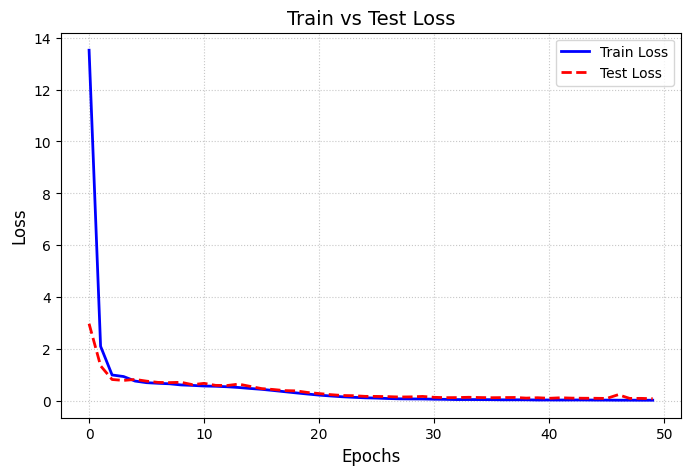

In [25]:
plt.figure(figsize=(8, 5))


plt.plot(epoch_train_losses, label='Train Loss', color='blue', linewidth=2)
plt.plot(epoch_test_losses, label='Test Loss', color='red', linestyle='--', linewidth=2)


plt.title('Train vs Test Loss', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)


plt.grid(True, linestyle=':', alpha=0.7)


plt.legend()


plt.show()

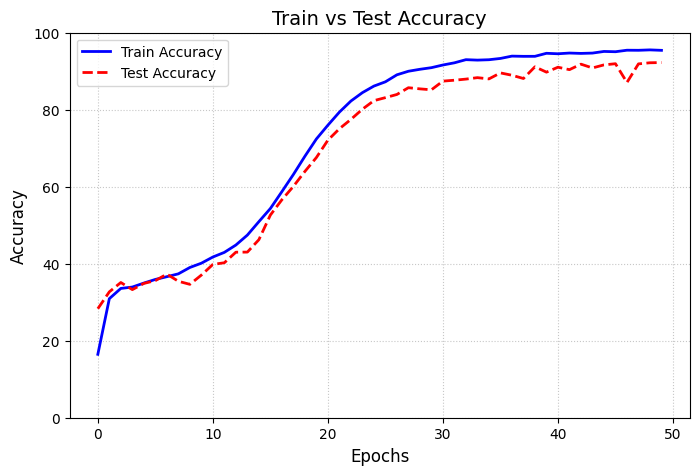

In [26]:
plt.figure(figsize=(8, 5))


plt.plot(epoch_train_accuracies, label='Train Accuracy', color='blue', linewidth=2)
plt.plot(epoch_test_accuracies, label='Test Accuracy', color='red', linestyle='--', linewidth=2)
plt.ylim(0, 100)

plt.title('Train vs Test Accuracy', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)


plt.grid(True, linestyle=':', alpha=0.7)


plt.legend()


plt.show()

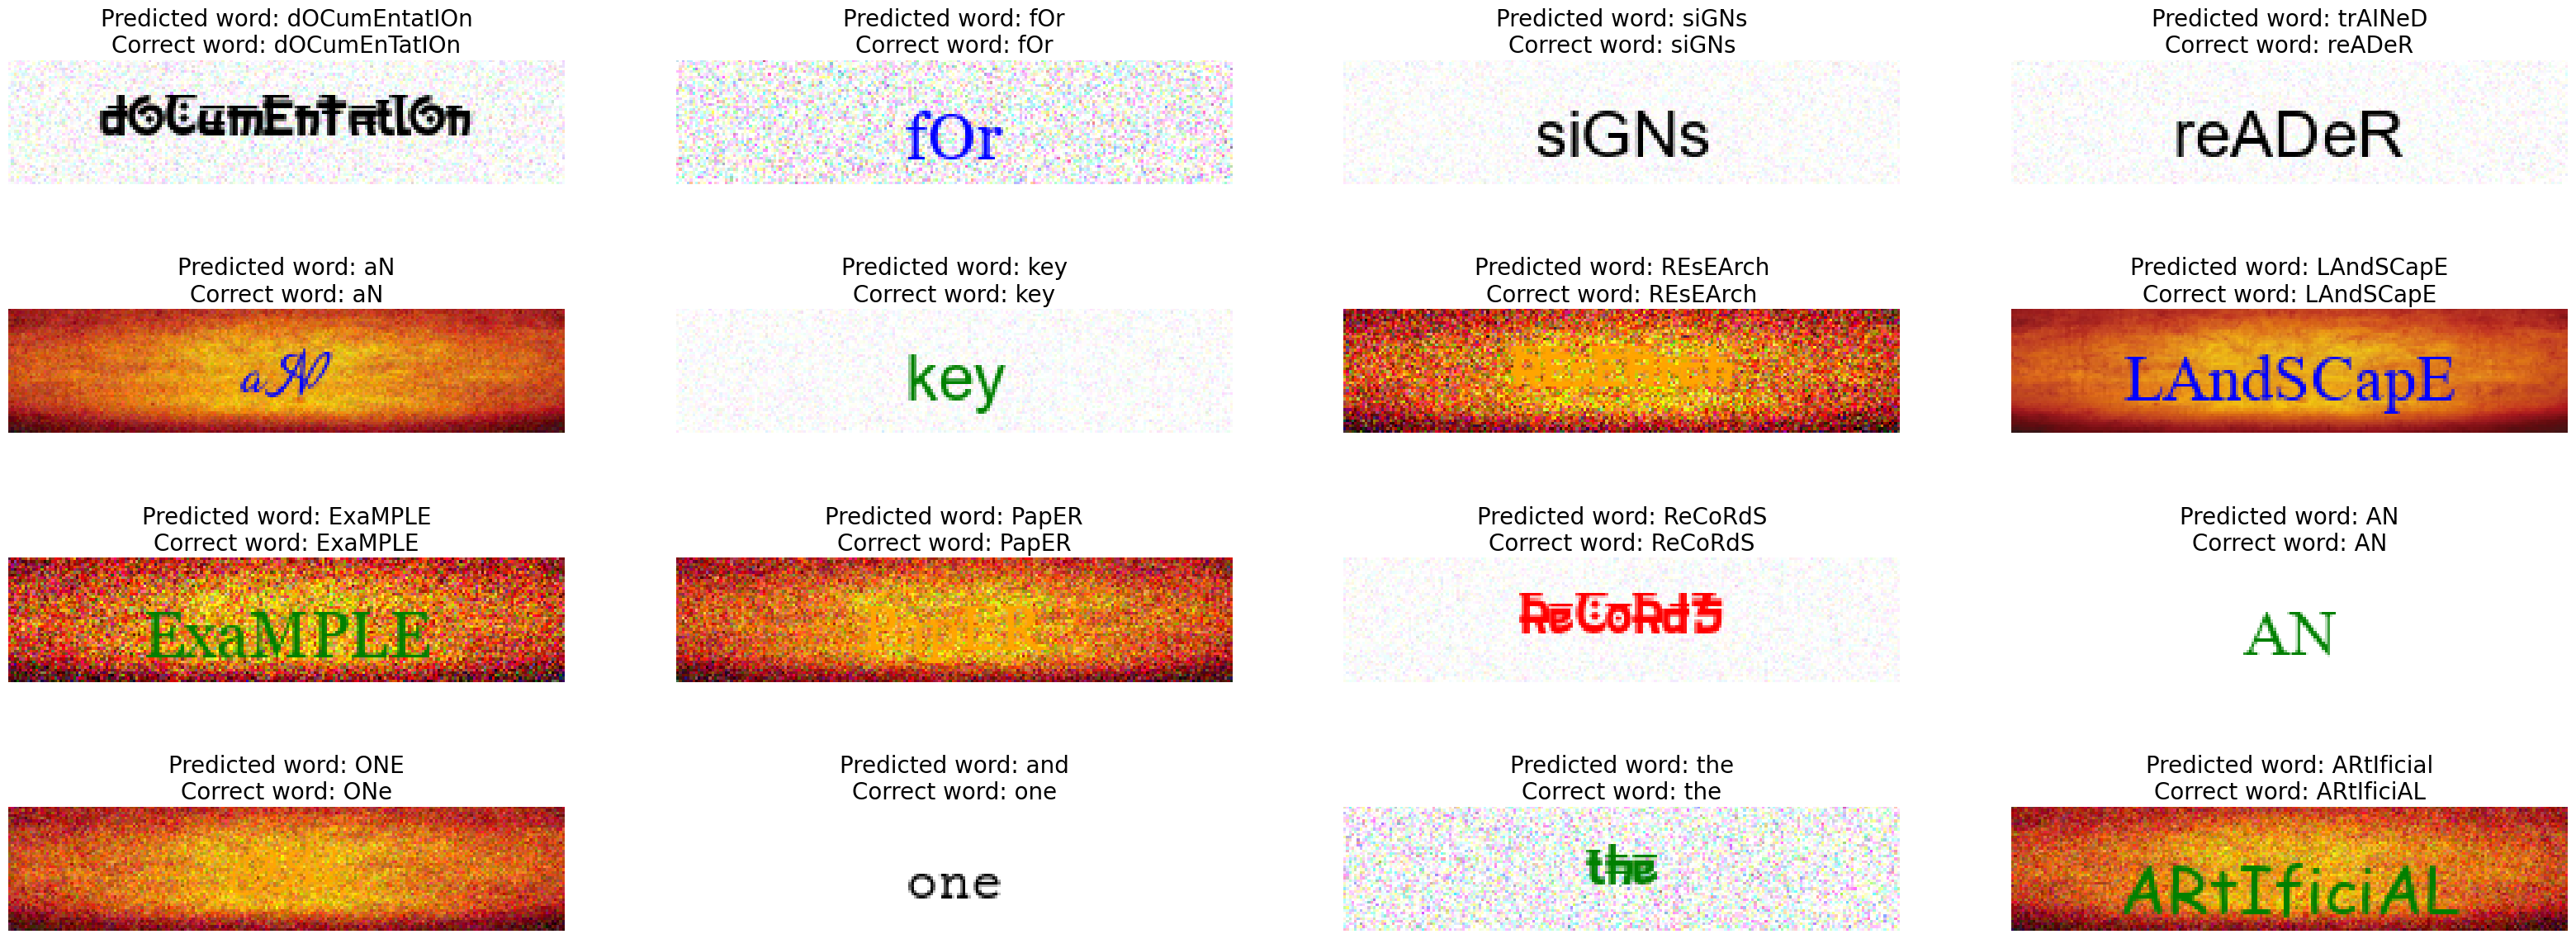

In [37]:
to_pil = transforms.ToPILImage()

fig, axes = plt.subplots(4, 4, figsize=(40, 15))

axes = axes.flatten()

indices = torch.randint(0, len(test_set), (16, ))

predicted_words = []

for i in range(16):
    # Initialize the idx with <bos> token
    # Randomly sample image from the test set and add bacth dimension
    idx = torch.tensor(word_2_token['<bos>']).reshape(1, 1).to(device)
    img = test_set[indices[i]][0].unsqueeze(0).to(device)

    # Get the generated tokens
    gen_idx = model.generate(img, idx, max_new_tokens=25)

    # Remove all the special tokens
    to_remove = [word_2_token['<bos>'], word_2_token['<eos>'], word_2_token['<pad>']]
    filtered = [x for x in gen_idx.squeeze().tolist() if x not in to_remove]

    # Convert all the tokens to letters and join them to get the predicted word
    pred_letters = [token_2_word[i] for i in filtered]
    pred_word = ''.join(pred_letters)
    predicted_words.append(pred_word)


for i in range(16):
    img, _, _, _, word = test_set[indices[i]]

    title = f'Predicted word: {predicted_words[i]}\nCorrect word: {word}'

    axes[i].set_title(title, fontsize=20)
    axes[i].imshow(to_pil(img))
    axes[i].axis('off')           # remove axis ticks and labels
    #axes[i].box(False)

plt.show()

In [30]:
model_path = os.path.join(r'/content/drive/MyDrive/Captcha', 'model.pth')
model_path

'/content/drive/MyDrive/Captcha/model.pth'

In [31]:
torch.save(model.state_dict(), model_path)

In [36]:
model2 = Transformer(
    H=H,
    W=W,
    n_channels=n_channels,
    n_embed=128,
    context_length=15,
    vocab_size=vocab_size,
    n_blocks=10,
    n_heads=16
).to(device)
model2.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [33]:
model2

Transformer(
  (embedding): Embedding(51, 128)
  (encoder): CNN_Encoder(
    (conv_block_1): Sequential(
      (0): Conv2d(3, 128, kernel_size=(2, 2), stride=(1, 1))
      (1): ReLU()
      (2): Conv2d(128, 128, kernel_size=(2, 2), stride=(1, 1))
      (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): ReLU()
    )
    (conv_block_2): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
      (1): ReLU()
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
      (3): ReLU()
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (avg_pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (decoders): ModuleList(
    (0-9): 10 x Decoder(
      (mhsa): Multi_Head_Self_Attention(
        (c_attn): Linear(in_features=128, out_features=384, bias=False)
        (c_proj): Linear(in_f